<a href="https://colab.research.google.com/github/p3dr0id/covid19oesteba/blob/main/metamodelo_regress%C3%A3o_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonte de dados

In [1]:
# import packages
import pandas as pd # dataframes
import numpy as np
import matplotlib.pyplot as plt # plotting data
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # serve para fazer inserção de gráficos como subplots


In [2]:
# Monta o Google Drive para carregar a fonte de dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/casos_acumulados_covid19_oeste_ba.csv')
df.head()

,data,Angical,Baianópolis,Barra,Barreiras,Bom Jesus da Lapa,Brejolândia,Brotas de Macaúbas,Buritirama,Canápolis,...,Santa Maria da Vitória,Santa Rita de Cássia,Santana,São Desidério,São Félix do Coribe,Serra do Ramalho,Serra Dourada,Sítio do Mato,Tabocas do Brejo Velho,Wanderley
0,2020-03-21,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-22,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-23,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-24,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-25,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Convertendo a coluna data no formato datetime
df['data'] = pd.to_datetime(df['data'])

In [5]:
# Coloca a coluna data como índice
df = df.set_index('data')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 818 entries, 2020-03-21 to 2022-06-16
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Angical                  818 non-null    int64
 1   Baianópolis              818 non-null    int64
 2   Barra                    818 non-null    int64
 3   Barreiras                818 non-null    int64
 4   Bom Jesus da Lapa        818 non-null    int64
 5   Brejolândia              818 non-null    int64
 6   Brotas de Macaúbas       818 non-null    int64
 7   Buritirama               818 non-null    int64
 8   Canápolis                818 non-null    int64
 9   Catolândia               818 non-null    int64
 10  Cocos                    818 non-null    int64
 11  Coribe                   818 non-null    int64
 12  Correntina               818 non-null    int64
 13  Cotegipe                 818 non-null    int64
 14  Cristópolis              818 non-null  

In [6]:
estados = df.columns.tolist()

# Aplicação dos modelos de regressão para projeções de casos acumulados

## Instalação de bibliotecas necessárias

In [7]:
!pip install pmdarima #instalar Auto-ARIMA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.2 MB/s 
     |████████████████████████████████| 9.8 MB 48.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [8]:
import time
import datetime
# Importação das biliotecas de regressão
import pmdarima as pm
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot
from sklearn.model_selection import train_test_split
# Importação das biliotecas de avaliação do erro
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Algumas funções importantes

In [ ]:
# Define a função para inserir linhas no dataframe.
def inserir_linha_dataframe(df, row):
    insert_loc = df.index.max()

    if np.isnan(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

In [ ]:
# Define a funcão para criar o modelo Prophet
def modelo_prophet(datas,  dados_serie):

    # Define o dataframe para input no modelo Prophet
    dados = pd.DataFrame({"ds": datas, "y": dados_serie})

    # Criação do modelo 
    modelo_pro=Prophet(daily_seasonality=False, weekly_seasonality = False, yearly_seasonality=False)

    # Treina o modelo
    modelo_pro.fit(dados)
   
    return modelo_pro

In [ ]:
# Define a função para criar o modelo Auto-Arima
def modelo_auto_arima(dados_serie):

    #Definição do modelo
    auto_arima_md = pm.auto_arima(dados_serie,  
                                    start_p=0, start_d=0 ,start_q=0,max_p=8, max_d=8,max_q=8, m=1, start_P=0, d=1, D=1,
                                    trace = False,
                                    error_action='ignore',  
                                    suppress_warnings=True,                                     
                                    stepwise=True 
                                  
                                 ) 

    #Treinamento do modelo
    auto_arima_md.fit(dados_serie)
    
    return auto_arima_md

In [ ]:
def comparacao_modelos(modeloaa, modelopp, janela_previsao, cid, dados_teste):
  
  df_result = pd.DataFrame(columns=['Data_inicial', 'Data_final','RMSE_FBProphet', 'RMSE_AArima', 'Estado'])

  for i in range(len(cid)):

    # Realiza a predição com o modelo auto_arima
    dias_previsao_auto_arima = modeloaa[i].predict(n_periods=janela_previsao)

    #Cria as datas futuras para previsão
    datas_previsao = modelopp[i].make_future_dataframe(periods=janela_previsao, freq='D')

    # Realiza a predição com o modelo prophet
    previsoes_prophet = modelopp[i].predict(datas_previsao)

    # Obtêm somente os dias previstos
    dias_previsao_prophet = previsoes_prophet[['ds','yhat']].tail(janela_previsao)

    # Calcula o erro do modelo.
    MSE_auto_arima  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_auto_arima)
    RMSE_auto_arima =  np.sqrt(MSE_auto_arima)

    MSE_Prophet  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_prophet.yhat)
    RMSE_Prophet =  np.sqrt(MSE_Prophet)
      
    # Insere o resultado do erro do modelo no dataframe
    inserir_linha_dataframe(df_result, [dados_teste.index[0],dados_teste.index[-1],RMSE_Prophet, RMSE_auto_arima, cid[i]])

  #df_result['Melhor_Modelo'] = np.where(df_result['RMSE_FBProphet'] > df_result['RMSE_AArima'], 'Arima', 'Prophet') # Cria coluna a mais com o modelo com medor RMSE para cada cidade
  
  df_result['Melhor_Modelo'] = df_result[['RMSE_FBProphet', 'RMSE_AArima']].idxmin(axis=1).replace({'RMSE_FBProphet':'Prophet', 'RMSE_AArima':'Arima'})
      
  return df_result

In [ ]:
def plot_comparacao_modelos(df_result, periodos):
  ax = df_result.plot(x='Estado', y=['RMSE_FBProphet', 'RMSE_AArima'], kind='bar', figsize=(20,10), fontsize=14)
  ax.legend(['RMSE (Facebook Prophet)', 'RMSE (Auto Arima)'], fontsize=14)
  axins0 = inset_axes(ax, width="40%", height="40%", loc=2)
  axins0.pie( df_result.groupby('Melhor_Modelo').size(), autopct='%1.1f%%', labels = [ 'Arima', 'Prophet'], colors = ['#ff7f0e', '#1f77b4'])
  axins0.set_title('Melhor modelo no período '+str(periodos)+' de '+df_result_list[periodos-1].loc[0][0]+' até '+df_result_list[periodos-1].loc[0][1], y=0.92, fontsize=14)
  ax.set_xlabel("")
  ax.set_title('Comparação das previsões dos modelos de regressão para os casos acumulados das cidades da Macrorregião Oeste da Bahia', fontsize=14)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/comparacao_modelos'+str(periodos)+'.png', dpi=150, bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
def plot_comparacao_modelos_arima(df_result_final, periodos):
  ax = df_result_final.plot(x='Estado',
                            y=['RMSE_MModelo', 'RMSE_AArima'],
                            kind='bar',
                            figsize=(20,10),
                            color = ['#2ca02c','#ff7f0e'])
  ax.legend(['RMSE (Meta Modelo)', 'RMSE (Auto Arima)'])
  axins0 = inset_axes(ax, width="40%", height="40%", loc=1)
  axins0.pie( df_result_final.groupby('Comp_Arima').size().reindex(['Arima', 'MModelo', 'Ambos']),
             autopct='%1.1f%%', labels = [ 'Arima', 'MModelo', 'Ambos'],
             colors = ['#ff7f0e', '#2ca02c', 'gray'])
  axins0.set_title("Melhor Modelo", y=0.95)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/comparacao_mmodelo_arima'+str(periodos)+'.png', dpi=150, bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
def plot_comparacao_modelos_prophet(df_result_final, periodos):
  ax = df_result_final.plot(x='Estado',
                            y=['RMSE_MModelo', 'RMSE_FBProphet'],
                            kind='bar',
                            figsize=(20,10),
                            color = ['#2ca02c','#1f77b4'])
  ax.legend(['RMSE (Meta Modelo)', 'RMSE (Facebook Prophet)'])
  axins0 = inset_axes(ax, width="40%", height="40%", loc=9)
  axins0.pie( df_result_final.groupby('Comp_Prophet').size().reindex(['Prophet', 'MModelo', 'Ambos']),
             autopct='%1.1f%%', labels = [ 'Prophet', 'MModelo', 'Ambos'],
             colors = ['#1f77b4', '#2ca02c', 'gray'])
  axins0.set_title("Melhor Modelo", y=0.92)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/comparacao_mmodelo_prophet'+str(periodos)+'.png', dpi=150, bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
def comparacao_modelos_final(modeloaa, modelopp, janela_previsao, cid, dados_teste, df_result):
  
  df_result_final = pd.DataFrame(columns=['Data_inicial', 'Data_final','RMSE_FBProphet', 'RMSE_AArima', 'RMSE_MModelo', 'Estado'])

  for i in range(len(cid)):

    # Realiza a predição com o modelo auto_arima
    dias_previsao_auto_arima = modeloaa[i].predict(n_periods=janela_previsao)

    #Cria as datas futuras para previsão
    datas_previsao = modelopp[i].make_future_dataframe(periods=janela_previsao, freq='D')

    # Realiza a predição com o modelo prophet
    previsoes_prophet = modelopp[i].predict(datas_previsao)

    # Obtêm somente os dias previstos
    dias_previsao_prophet = previsoes_prophet[['ds','yhat']].tail(janela_previsao)

    # Calcula o erro do modelo.
    MSE_auto_arima  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_auto_arima)
    RMSE_auto_arima =  np.sqrt(MSE_auto_arima)

    MSE_Prophet  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_prophet.yhat)
    RMSE_Prophet =  np.sqrt(MSE_Prophet)

    if (df_result.set_index('Estado').loc[cid[i]].Melhor_Modelo == 'Prophet'):
      datas_previsao = modelopp[i].make_future_dataframe(periods=janela_previsao, freq='D')
      previsoes_prophet = modelopp[i].predict(datas_previsao)
      dias_previsao_prophet = previsoes_prophet[['ds','yhat']].tail(janela_previsao)
      MSE_meta_modelo  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_prophet.yhat)
      RMSE_meta_modelo =  np.sqrt(MSE_meta_modelo)
    else:
      dias_previsao_auto_arima = modeloaa[i].predict(n_periods=janela_previsao)
      MSE_meta_modelo  =  mean_squared_error(dados_teste[cid[i]], dias_previsao_auto_arima)
      RMSE_meta_modelo =  np.sqrt(MSE_meta_modelo)

      
    # Insere o resultado do erro do modelo no dataframe
    inserir_linha_dataframe(df_result_final, [dados_teste.index[0],dados_teste.index[-1],RMSE_Prophet, RMSE_auto_arima, RMSE_meta_modelo, cid[i]])

  
  #df_result_final['Melhor_Modelo'] = df_result_final[['RMSE_MModelo','RMSE_FBProphet', 'RMSE_AArima']].idxmin(axis=1).replace({'RMSE_FBProphet':'Prophet', 'RMSE_AArima':'Arima', 'RMSE_MModelo':'MModelo'})
  condicoes_arima = [df_result_final['RMSE_MModelo'] < df_result_final['RMSE_AArima'],
                     df_result_final['RMSE_MModelo'] > df_result_final['RMSE_AArima']]
  escolhas_arima = ['MModelo', 'Arima']
  df_result_final['Comp_Arima'] = np.select(condicoes_arima, escolhas_arima, default='Ambos')

  condicoes_prophet = [df_result_final['RMSE_MModelo'] < df_result_final['RMSE_FBProphet'],
                       df_result_final['RMSE_MModelo'] > df_result_final['RMSE_FBProphet']]
  escolhas_prophet = ['MModelo', 'Prophet']
  df_result_final['Comp_Prophet'] = np.select(condicoes_prophet, escolhas_prophet, default='Ambos')
      
  return df_result_final

In [ ]:
def treina_modelos(modelo_pp, modelo_aa, df_regress, janela, estados):
  x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(df_regress.index,
                                                                    df_regress, 
                                                                    test_size = janela/len(df_regress), 
                                                                    shuffle = False)

  for i in range(len(estados)):
    modelo_pp.append(modelo_prophet(x_treinamento, y_treinamento[estados[i]]))
    modelo_aa.append(modelo_auto_arima(y_treinamento[estados[i]]))

  return y_teste


## Treinamento dos modelos Prophet e Auto Arima para comparação das previsões

In [ ]:
def validacao_modelos():

  for periodos in range(1,6):
    janela = 30 # Especifica a quantidade de dias que será utilizada para validar e testar os modelos
    data_valid = df.index[-1] - datetime.timedelta(days=periodos*janela)
    data_teste = data_valid + datetime.timedelta(days=janela)
    df_valid = df[:data_valid].copy()
    df_teste = df[:data_teste].copy()
    df_regress = df_valid.copy()
    x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(df_regress.index,
                                                                      df_regress, 
                                                                      test_size = janela/len(df_regress), 
                                                                      shuffle = False)
    dias_valid = len(x_teste)

    tempo_inicial = time.time()

    modelo_pp = []
    modelo_aa = []

    datas_valid = treina_modelos(modelo_pp, modelo_aa, df_valid, janela, estados)

    tempo_final = (time.time() - tempo_inicial)/60
    print("O tempo de execução do período " +str(periodos)+" foi de: {} minutos".format(tempo_final))

    df_result = comparacao_modelos(modelo_aa, modelo_pp, dias_valid, estados, datas_valid)
    df_result.to_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao'+str(periodos)+'.csv', index=False)

In [ ]:
#validacao_modelos()

## Plot de gráficos com a comparação das previsões com os dados de validação

In [ ]:
df_result_list = []
df_result_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao1.csv'))
df_result_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao2.csv'))
df_result_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao3.csv'))
df_result_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao4.csv'))
df_result_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_validacao5.csv'))

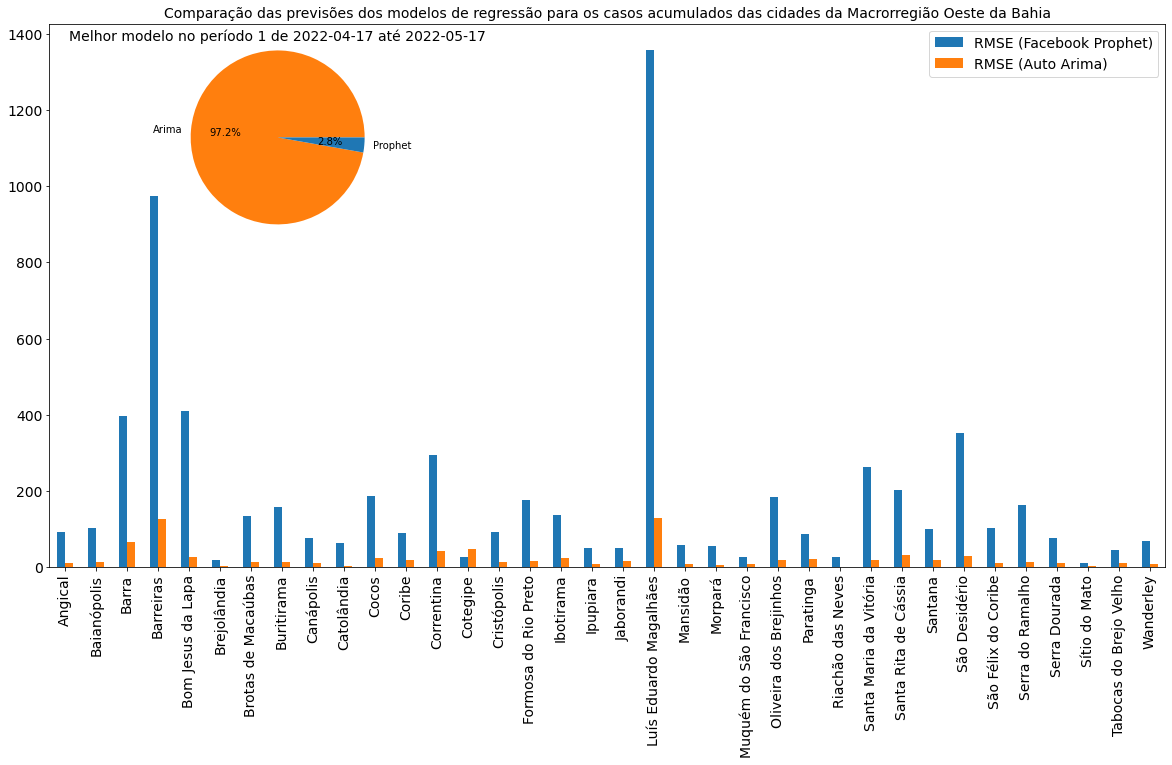

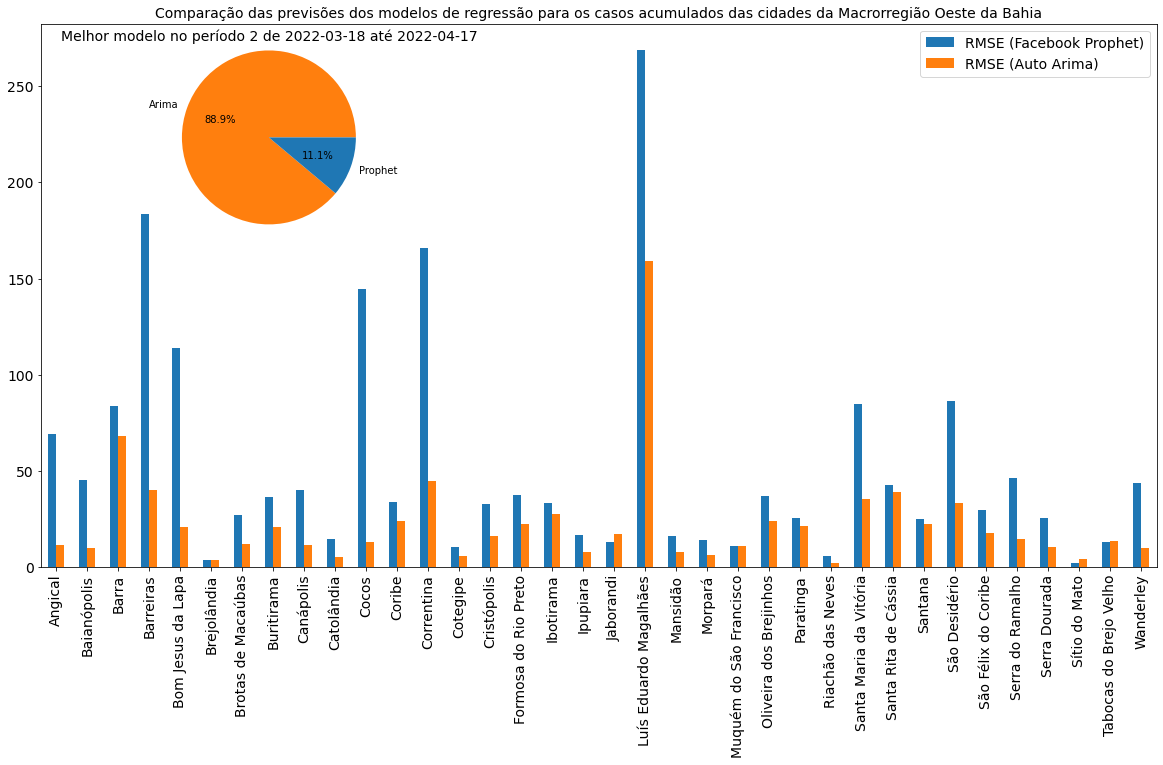

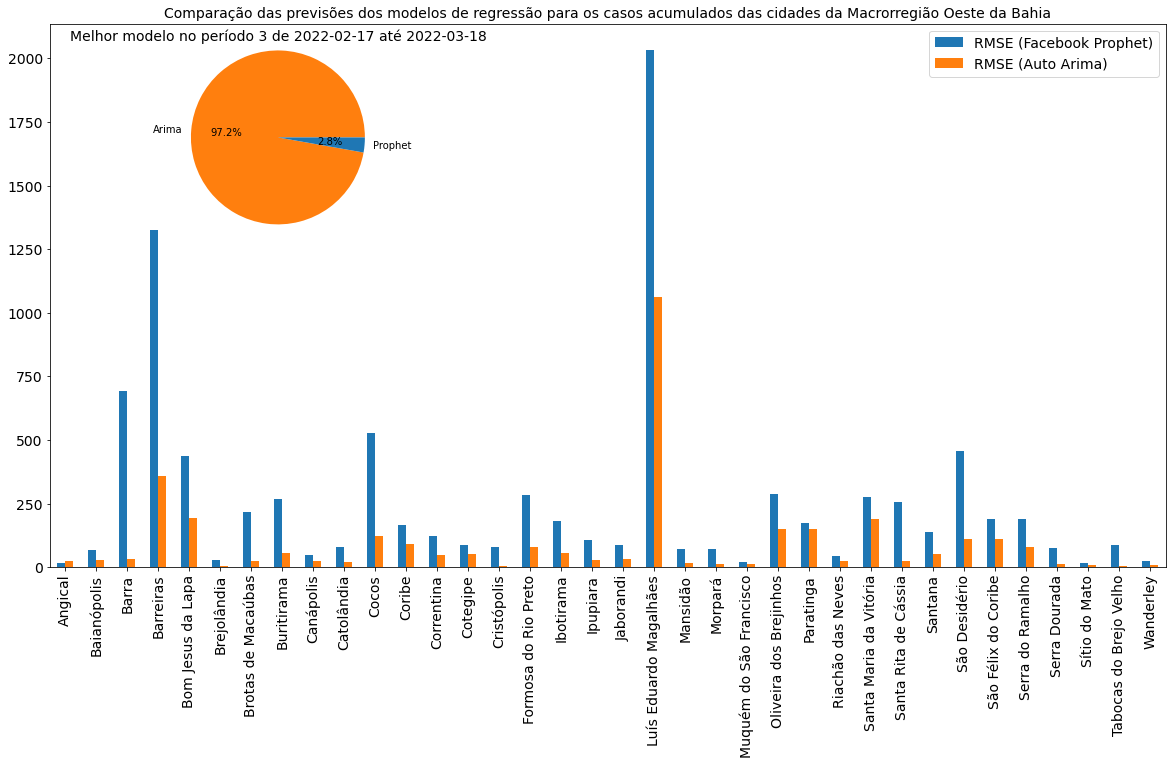

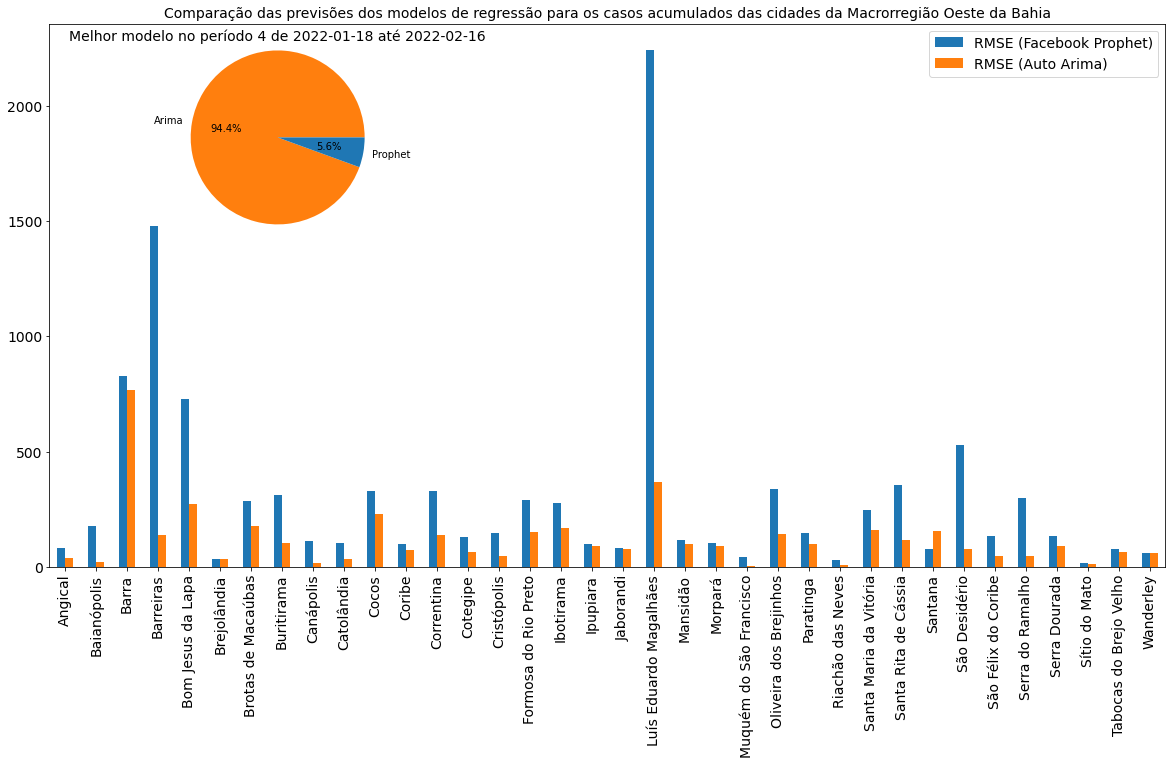

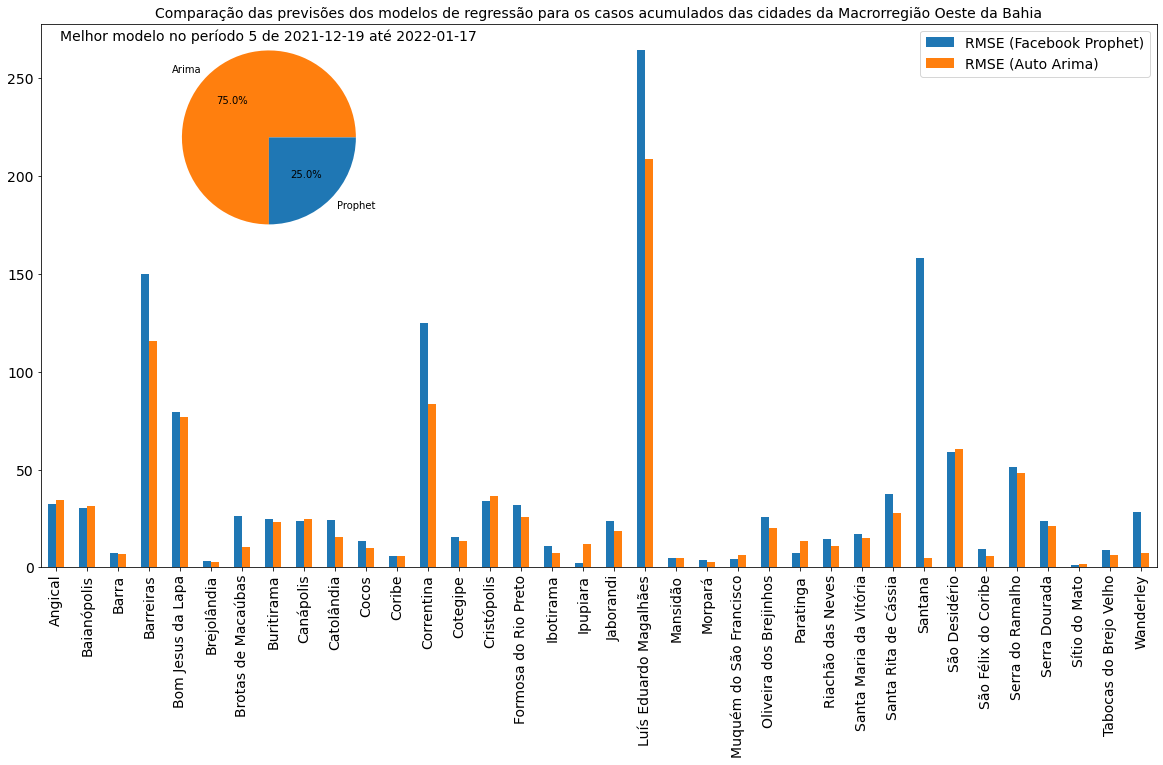

In [ ]:
for periodos in range(1,6):
  plot_comparacao_modelos(df_result_list[periodos-1], periodos)

# Aplicação do Metamodelo de Regressão

## Treina metamodelo e compara com os outros modelos

In [ ]:
def teste_modelos():
  
  for periodos in range(1,6):
    janela = 30 # Especifica a quantidade de dias que será utilizada para validar e testar os modelos
    data_valid = df.index[-1] - datetime.timedelta(days=periodos*janela)
    data_teste = data_valid + datetime.timedelta(days=janela)
    df_valid = df[:data_valid].copy()
    df_teste = df[:data_teste].copy()
    df_regress = df_teste.copy()
    x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(df_regress.index,
                                                                      df_regress, 
                                                                      test_size = janela/len(df_regress), 
                                                                      shuffle = False)
    dias_valid = len(x_teste)
    print('dias_valid = ', dias_valid)

    tempo_inicial = time.time()

    modelo_pp_final = []
    modelo_aa_final = []
    datas_teste = treina_modelos(modelo_pp_final, modelo_aa_final, df_teste, janela, estados)

    tempo_final = (time.time() - tempo_inicial)/60
    print("O tempo de execução do período " +str(periodos)+" foi de: {} minutos".format(tempo_final))
    df_result_final = comparacao_modelos_final(modelo_aa_final, modelo_pp_final, dias_valid, estados, datas_teste, df_result_list[periodos-1])

    df_result_final.to_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste'+str(periodos)+'.csv', index=False)

dias_valid =  31
O tempo de execução do período 1 foi de: 17.196637765566507 minutos
dias_valid =  31
O tempo de execução do período 2 foi de: 15.887975148359935 minutos
dias_valid =  31
O tempo de execução do período 3 foi de: 15.163759573300679 minutos
dias_valid =  30
O tempo de execução do período 4 foi de: 14.079511221249899 minutos
dias_valid =  30
O tempo de execução do período 5 foi de: 10.670053923130036 minutos


In [ ]:
#teste_modelos()

## Plot de gráficos com a comparação das previsões com os dados de teste

In [ ]:
df_result_final_list = []
df_result_final_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste1.csv'))
df_result_final_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste2.csv'))
df_result_final_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste3.csv'))
df_result_final_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste4.csv'))
df_result_final_list.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC Ciência de Dados PUC - MG/dados_resultado_teste5.csv'))

In [ ]:
for periodos in range(5,6):
  plot_comparacao_modelos_arima(df_result_final_list[periodos-1], periodos)

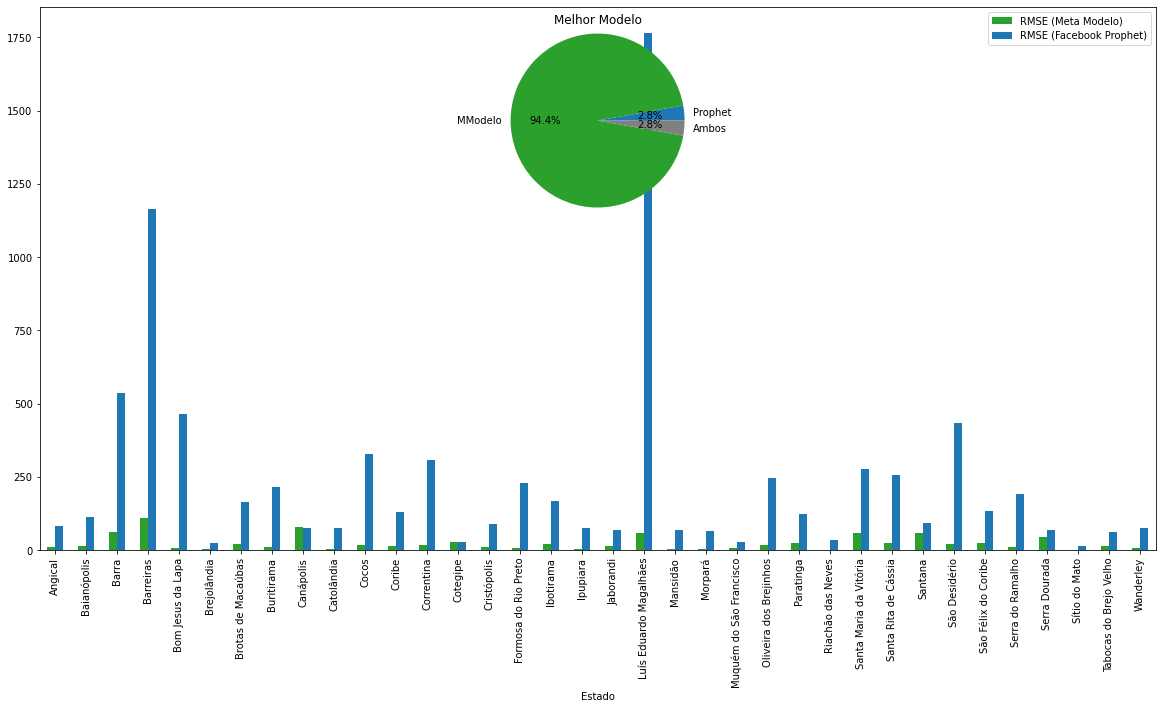

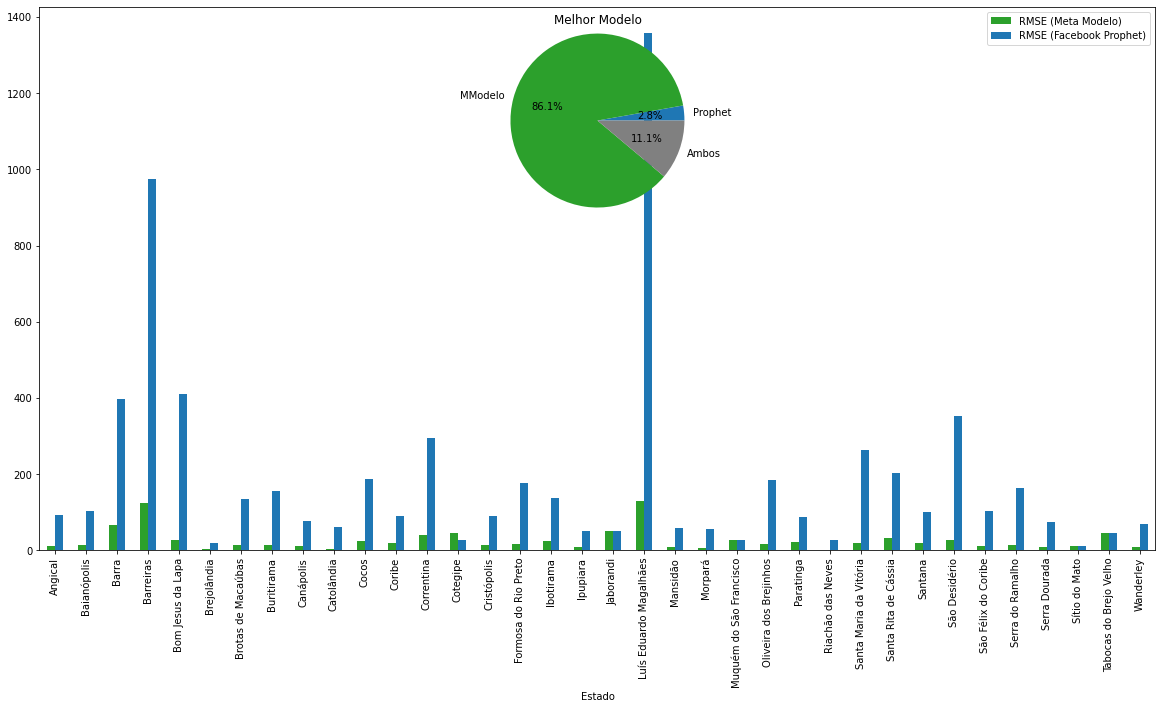

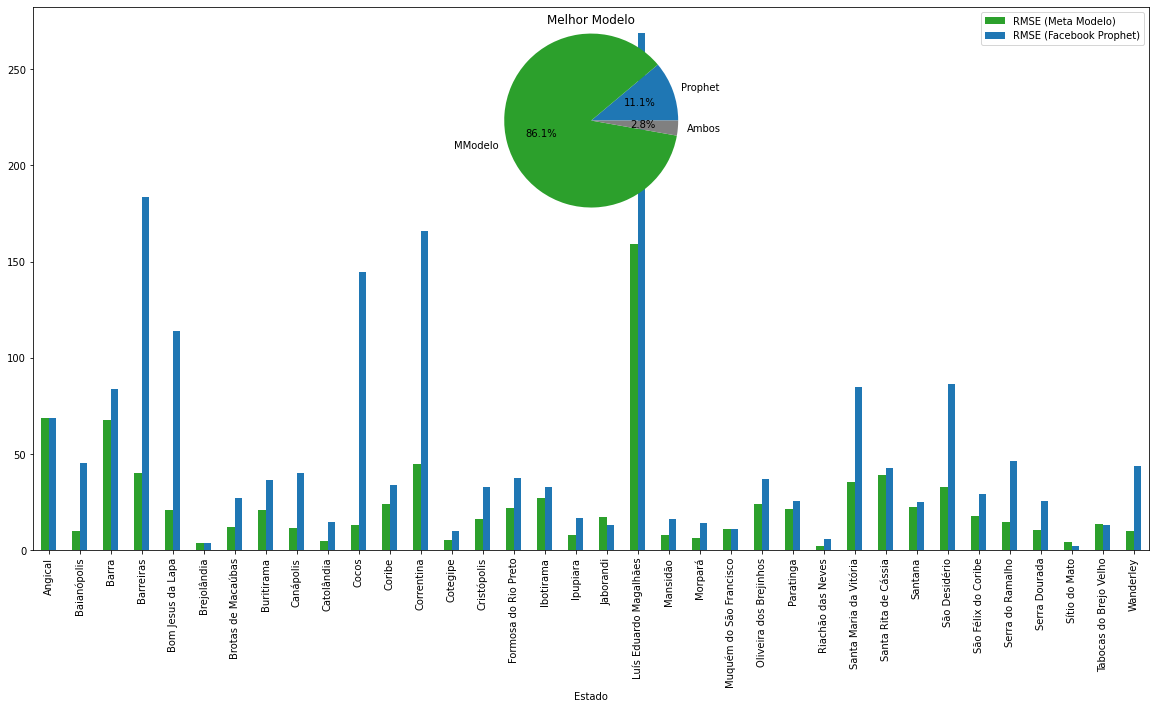

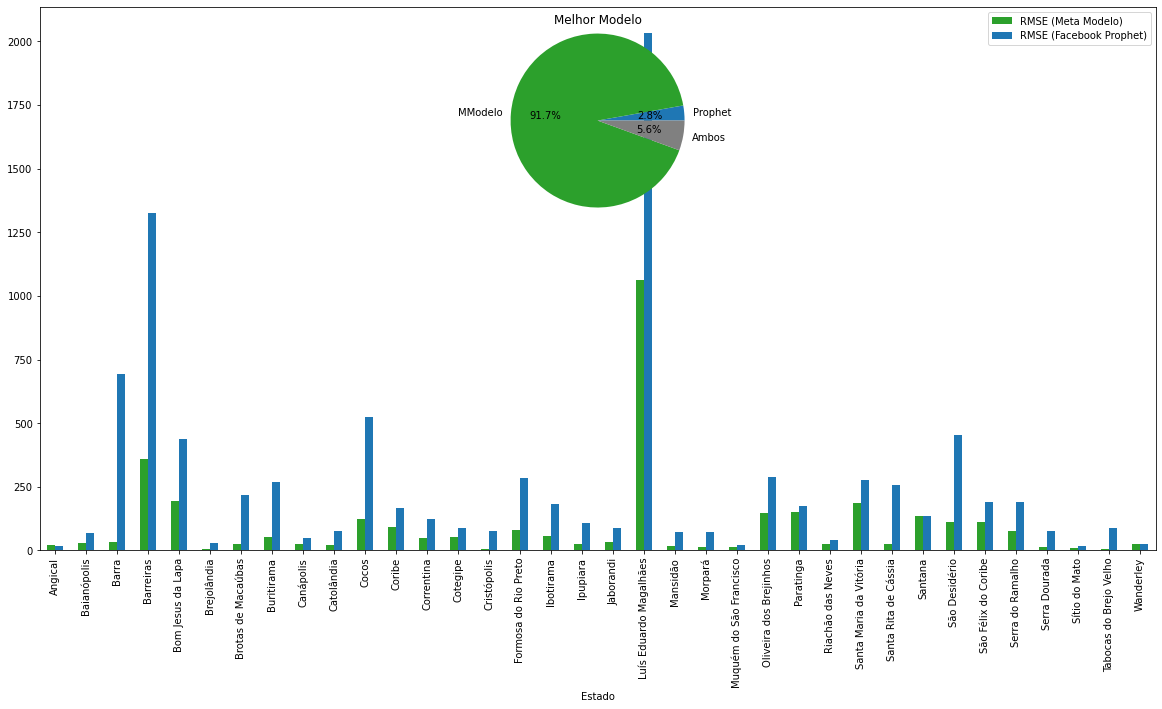

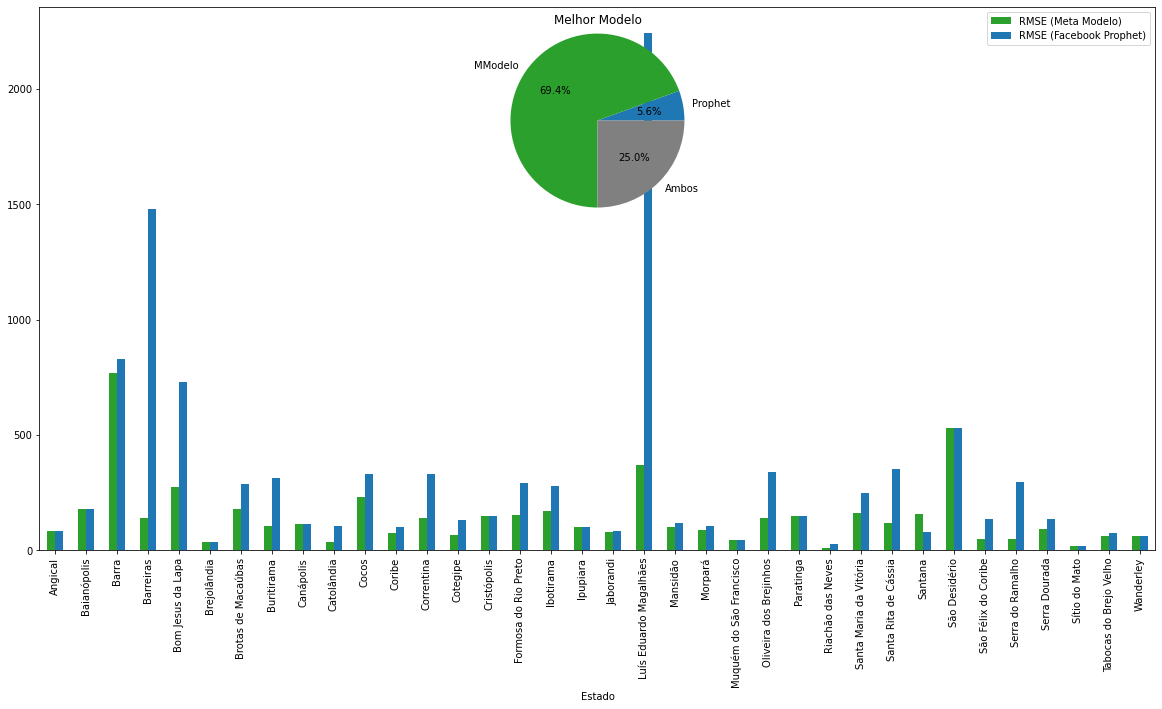

In [ ]:
for periodos in range(1,6):
  plot_comparacao_modelos_prophet(df_result_final_list[periodos-1], periodos)
